In [2]:
######## Imports ########
import numpy as np
import pandas as pd
import sys


from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# Converting labels to 1-Hot Vectors
# from sklearn.preprocessing import OneHotEncoder

from sklearn.utils.multiclass import unique_labels

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##########################

root_logdir = "./tf_logs"
datadir = "data/"
figures_dir = "data/figures/"

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16

np.random.seed(seed=42)

from helper import *

# To plot pretty figures
# %matplotlib widget

## Half the data will be split out as validation and 0.2 as the test set

In [3]:
from scipy.stats import entropy
'''
Expects data to be 2D numpy array
'''
def calculateEntropy(data, plot=False):
    from scipy.stats import entropy
    
    nsamples = len(data)
    nbins = 15

    xedges = np.linspace(0,15,nbins+1)
    yedges = np.linspace(0,15,nbins+1)
    
    x = np.clip(data[:,0], xedges[0], xedges[-1])
    y = np.clip(data[:,1], yedges[0], yedges[-1])
    
    grid, xedges, yedges = np.histogram2d(x, y, bins=[xedges,yedges])
    densities = (grid/nsamples).flatten()
    
    if plot:
        fig, ax = plt.subplots(1, figsize=(14, 14))

        ax.imshow(grid, interpolation='nearest', origin='low',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="jet")
#         plt.colorbar()
        plt.show()
    
    return entropy(densities)

In [4]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    keras.backend.clear_session()
    
    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = num_nodes, activation=activation, input_dim=num_features,
                kernel_initializer=he_init))
    
    for i in range(1,depth):
        nn.add(Dense(units = num_nodes, activation=activation,
                    kernel_initializer=he_init))

    nn.add(Dense(units=num_labels, activation= "softmax",
                kernel_initializer=he_init))
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, epochs=30, batch_size=20, verbose=0):
    from sklearn.preprocessing import StandardScaler
    from imblearn.over_sampling import SMOTE
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    y_train = hot_encoder.transform(y)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose=verbose)
    
    return history, ZScaler

'''
Assumes categorical output from DNN
'''
def getCorrectPredictions(model, samples, labels, enc):
    import numpy as np
    
    predictions = model.predict(samples)
    preds = np.array([np.argmax(x) for x in predictions])
    true_labels = np.array([x for x in labels])

    correct = preds == true_labels
    
    return samples[correct], labels[correct], correct


Creating data...


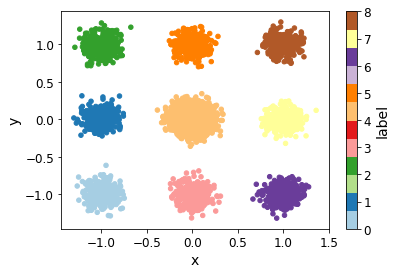

In [5]:
from multiprocessing import Pool
from time import time
from sklearn.model_selection import StratifiedShuffleSplit


depth_epochs = [(2,50),(3,50)]
# depth_epochs = [(2,50),(3,50),(4,100),(5,100), (5,200), (6,100)]

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=3000)
X, y, y_original, X_valid, y_valid, y_valid_original = split_valid(modded_samples, original_labels, training_labels)

num_features = X.shape[1]

hot_encoder = dfHotEncoder()
hot_encoder.fit(y)


def runDNN(depth, epochs, train_data, test_data):
    import innvestigate
    import innvestigate.utils as iutils
    
    X_train, y_train = train_data
    X_test, y_test = test_data
    
    nn = build_dnn(num_features)


    history, ZScaler = train_model(nn, X_train, y_train, 
                                   epochs=epochs, batch_size=20)

    scaled_samples = ZScaler.transform(X_test)
    final_acc = nn.evaluate(scaled_samples,hot_encoder.transform(y_test), verbose=0)

    # Getting all the samples that can be correctly predicted
    all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_test, enc = hot_encoder)

    # Stripping the softmax activation from the model
    model_w_softmax = nn
    model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    lrp_results = lrp_E.analyze(all_samples)

    return (final_acc, lrp_results, correct_idxs)

def runCV(depth,epoch):
    
    start_time = time()
    
    histories = []
    testing_indxs =[]
    predictions = []
    true_labels = []
    cv_original_labels = []
    cv_lrp_results = []
    zoo = []
    
    for i, (train_index, test_index) in enumerate(getKF(X, y_original)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test  = X.iloc[test_index]
        y_test = y.iloc[test_index]
        y_test_original = y_original.iloc[test_index]

        final_acc, lrp_results, lrp_idxs = runDNN(depth, epoch, train_data = [X_train,y_train], test_data = [X_test, y_test])

        cv_original_labels.extend(y_test_original[lrp_idxs])
        cv_lrp_results.extend(lrp_results)

        print("{}/{}, Fold {} scores: loss={:0.3f} accuracy={:.4f}".format(
            depth, epoch, i, final_acc[0], final_acc[1]))

    print("{}/{} Runtime: {:.3f}s".format(depth, epoch, time()-start_time))

    return (cv_lrp_results, cv_original_labels)

In [6]:
# depth_epochs = [(2,50), (3,75), (4,100), (5,200), (6,300)]
depth_epochs = [(2,50),(3,50)]
print("Starting pool execution...")

num_procs = 4
results = []
if __name__ == '__main__':
    with Pool(processes = num_procs) as pool:
        curr = 0
#         while curr < len(depth_epochs):
#             param_list = depth_epochs[curr: curr+num_procs]
#             curr += num_procs-1
        
        results.extend(pool.starmap(runCV, [(depth,epoch) for depth,epoch in depth_epochs]))

# pool.close()
# pool.join()
print("Done training DNNs")

# print(results)

Starting pool execution...


Using TensorFlow backend.
Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.



/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Instructions for updating:
Use tf.cast instead.WARNING:tensorflow:From /Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
3/50, Fold 0 scores: loss=0.002 accuracy=1.0000
2/50, Fold 0 scores: loss=0.002 accuracy=1.0000
3/50, Fold 1 scores: loss=0.001 accuracy=1.0000
2/50, Fold 1 scores: loss=0.002 accuracy=1.0000
3/50, Fold 2 scores: loss=0.002 accuracy=1.0000
2/50, Fold 2 scores: loss=0.001 accuracy=1.0000
2/50, Fold 3 scores: loss=0.001 accuracy=1.0000
3/50, Fold 3 scores: loss=0.001 accuracy=1.0000
2/50, Fold 4 scores: loss=0.002 accuracy=1.0000
3/50, Fold 4 scores: loss=0.001 accuracy=1.0000
2/50, Fold 5 scores: loss=0.002 acc

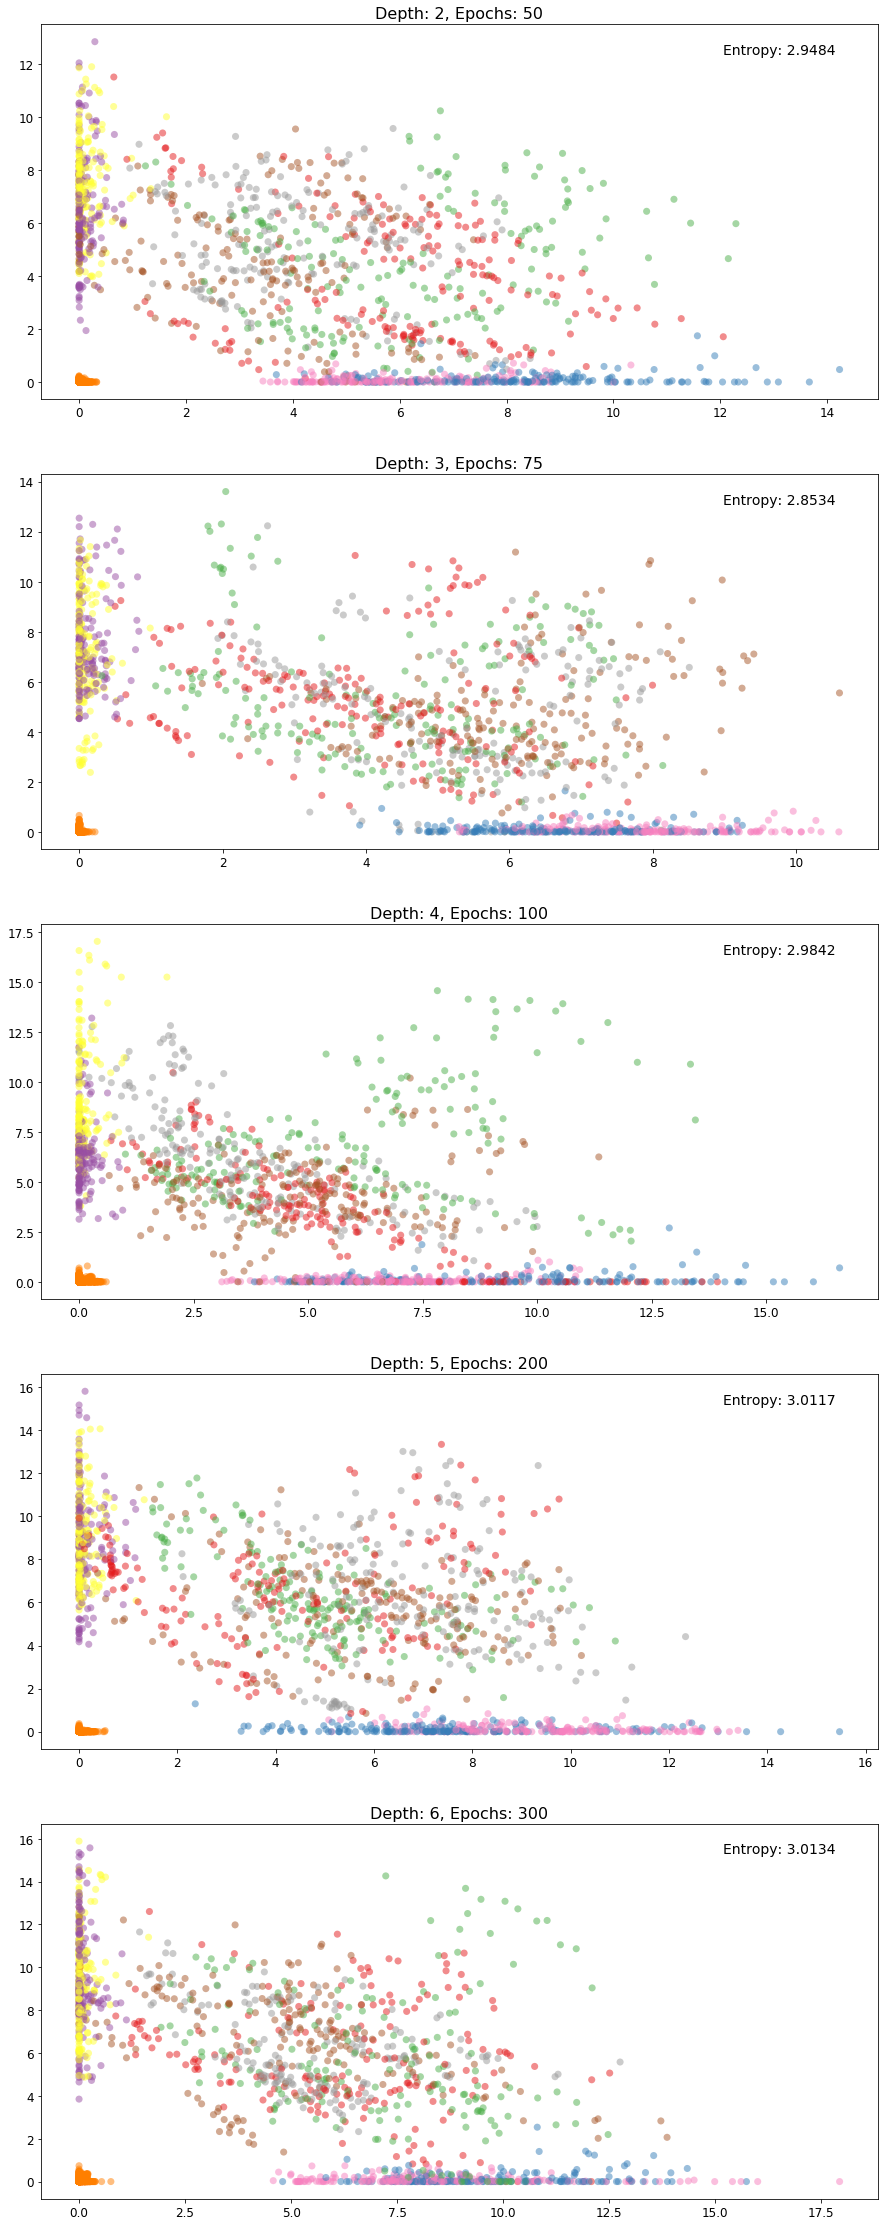

In [6]:
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": "Set1", "s":10, "alpha":0.25}

plt.close("Depth Comparison")
fig, axs = plt.subplots(len(depth_epochs),1, figsize=(15,8*len(depth_epochs)), num="Depth Comparison")
# plt.tight_layout()

entropies = []

for i,(d, epochs) in enumerate(depth_epochs):
    
    lrp_results, lrp_labels = results[i]
    
    pos_lrp = np.array(lrp_results)
    pos_lrp[pos_lrp<0] = 0
    data = pos_lrp
    lrp_entropy = calculateEntropy(data)
    entropies.append(lrp_entropy)
    
    axs[i].scatter(*data.T, s=50, linewidth=0, c=lrp_labels, alpha=0.5, cmap=plot_args["cmap"])
    axs[i].set_title("Depth: {}, Epochs: {}".format(d, epochs))
    axs[i].text(0.95,0.95,"Entropy: {:.4f}".format(lrp_entropy),
            horizontalalignment='right', verticalalignment='top',
            fontsize=14, transform=axs[i].transAxes)

In [7]:
# plt.savefig(figures_dir + "dCV_3-6.png")

<Figure size 432x288 with 0 Axes>

In [26]:
ents = pd.DataFrame(entropies, index=[d for d,e in depth_epochs], columns=["entropy"])
ents

,entropy
2,2.948416
3,2.853385
4,2.984188
5,3.011661
6,3.013432


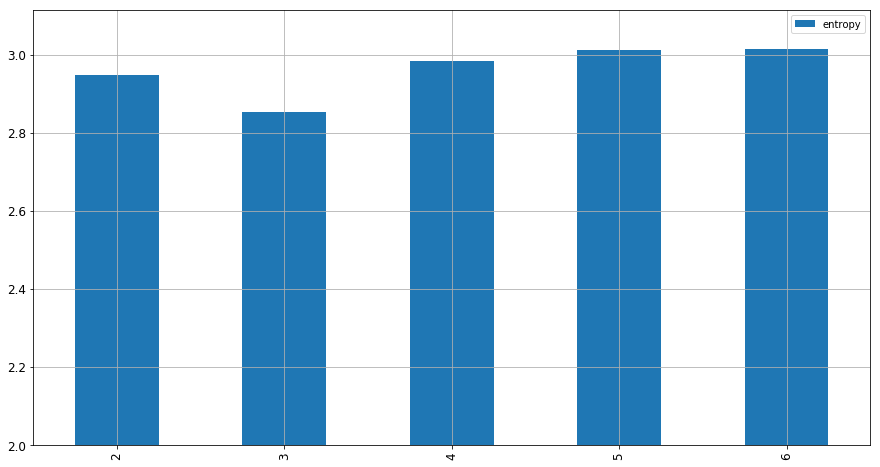

In [47]:
plt.close("Entropies Comparison")
fig, axs = plt.subplots(1, figsize=(15,8), num="Entropies")

ylim= (np.floor(ents.values.min()), (ents.values.max()+0.1))
ents.plot(kind="bar", ax=axs, ylim=ylim, grid=True)
plt.show()

## Comparing Epochs for depth=5

In [41]:
depth_epochs = [(5,100), (5,150), (5,200), (5,250), (5,300)]
# depth_epochs = [(2,50),(3,50)]
print("Starting pool execution...")

num_procs = 4
results = []
if __name__ == '__main__':
    with Pool(processes = num_procs) as pool:       
        results.extend(pool.starmap(runCV, [(depth,epoch) for depth,epoch in depth_epochs]))

# pool.close()
# pool.join()
print("Done training DNNs")

Starting pool execution...


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.WARNING:tensorflow:From /Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.mat

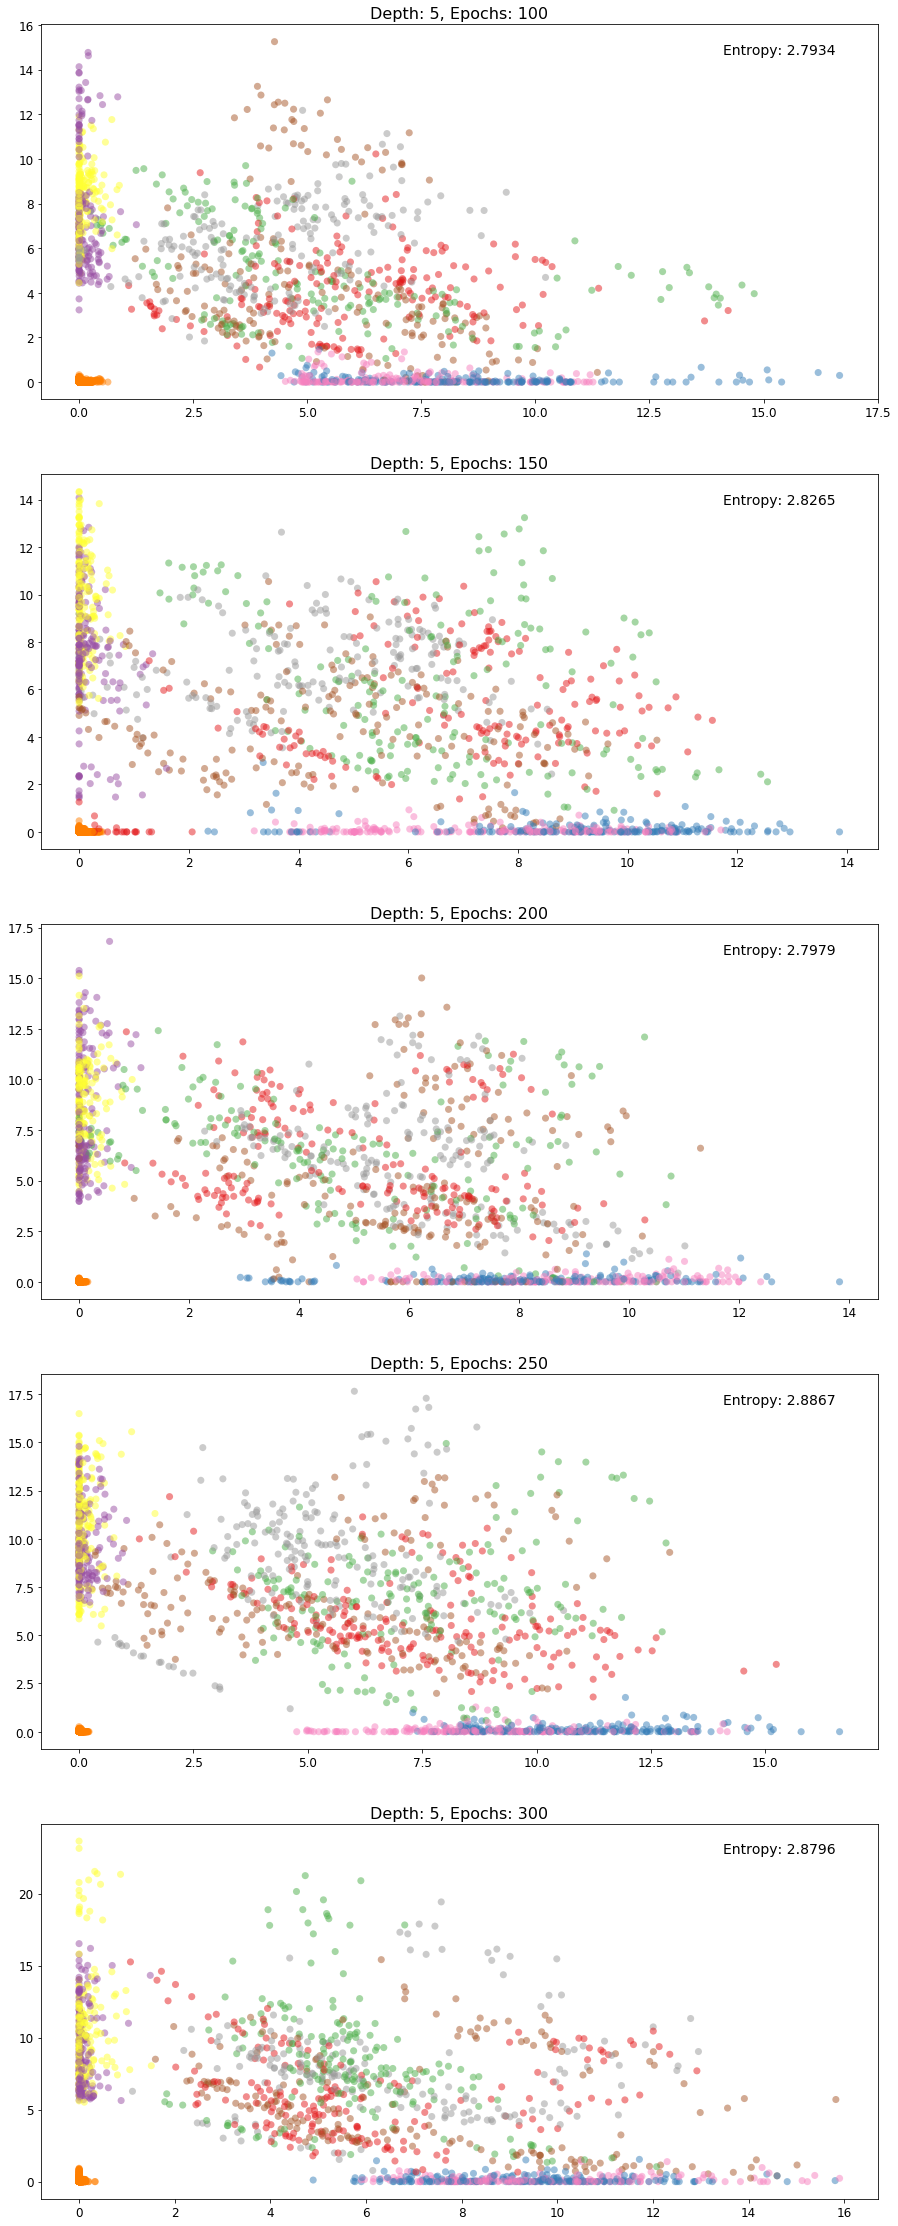

In [46]:
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": "Set1", "s":10, "alpha":0.25}

plt.close("Depth Comparison")
fig, axs = plt.subplots(len(depth_epochs),1, figsize=(15,8*len(depth_epochs)), num="Depth Comparison")
# plt.tight_layout()

entropies = []

for i,(d, epochs) in enumerate(depth_epochs):
    
    lrp_results, lrp_labels = results[i]
    
    pos_lrp = np.array(lrp_results)
    pos_lrp[pos_lrp<0] = 0
    data = pos_lrp
    lrp_entropy = calculateEntropy(data)
    entropies.append(lrp_entropy)
    
    axs[i].scatter(*data.T, s=50, linewidth=0, c=lrp_labels, alpha=0.5, cmap=plot_args["cmap"])
    axs[i].set_title("Depth: {}, Epochs: {}".format(d, epochs))
    axs[i].text(0.95,0.95,"Entropy: {:.4f}".format(lrp_entropy),
            horizontalalignment='right', verticalalignment='top',
            fontsize=14, transform=axs[i].transAxes)